# CS 544 MP 2 Solution
### Jae Yong Lee - lee896

## Problem Statement
Use the augmented Lagrangian method to find a surface that minimises smoothness cost while interpolating points given below.

1. You should represent the surface as a height map on a 256 x 256 grid, representing the unit square. 
2. You should represent the surface as a height map.
3. You should measure the smoothness as the norm of the gradient of the height map. 
4. The points to interpolate are: 
  (0, 0, 1); 
  (0, 1/2, 0); 
  (0, 1, 1); 
  (1/2, 0, 0); 
  (1/2, 1/2, 1); 
  (1/2, 1, 0); 
  (1, 0, 1); 
  (1, 1/2, 0); 
  (1, 1, 1). 
5. You should use a second order method to do the inner optimization (fminunc) but be careful - you don't want to build a (256x256) x (256x256) Hessian!


## Problem Solution
We first start by creating necessary variables

In [30]:
import numpy as np
from scipy import sparse
from scipy.optimize import fmin_ncg, fmin_l_bfgs_b
import time
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

WIDTH = 256
PIXELS = WIDTH ** 2

In [2]:
def plot_height_map(hm):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y = np.meshgrid(range(WIDTH), range(WIDTH))
    ax.plot_surface(x / WIDTH, y / WIDTH, hm / WIDTH)

For simplicy, we denote that index of ix, iy in unit square to be mapped into coordinates x, y in height_map  as:
```
x => ix * 256 - 1 and y => iy * 256 - 1 and z => h * 256 - 1
```
i.e) index (0, 1, 1) => (0, 255, 255), index (1/2, 1, 0) => (127, 255, 0) etc.

In [3]:
height_map = np.zeros((WIDTH, WIDTH), np.float32)

interpolations = np.array([
    [0, 0, WIDTH],
    [0, WIDTH//2-1, 0],
    [0, WIDTH-1, WIDTH],
    [WIDTH//2-1, 0, 0],
    [WIDTH//2-1, WIDTH//2-1, WIDTH],
    [WIDTH//2-1, WIDTH-1, 0],
    [WIDTH-1, 0, WIDTH],
    [WIDTH-1, WIDTH//2-1, 0],
    [WIDTH-1, WIDTH-1, WIDTH]
])

coords = interpolations[:, :2]
values = interpolations[:, 2]

height_map[coords[:, 0], coords[:, 1]] = values
num_intp = values.shape[0]

We then create matrix representation of finite difference derivatives in each coordinates, namely dx and dy

In [4]:
diag_main = np.ones((PIXELS,)) * -1

dx_diag_prev = np.zeros((PIXELS-WIDTH,), np.float)
dx_diag_next = np.ones((PIXELS-WIDTH,), np.float)

dx_diag_prev[PIXELS - 2*WIDTH:] = 1


dx_offsets = np.array([-WIDTH, 0, WIDTH])
dx_r = sparse.diags([dx_diag_prev, diag_main, dx_diag_next], dx_offsets)
dx = dx_r  * 1

dy_diag_prev = np.zeros((PIXELS-1,), np.float)
dy_diag_next = np.ones((PIXELS-1,), np.float)
for i in range(1, WIDTH):
    dy_diag_prev[i * WIDTH - 2] = 1
    dy_diag_next[i * WIDTH - 1] = 0
dy_diag_prev[-1] = 1
dy_offsets = np.array([-1, 0, 1])
dy_r = sparse.diags([dy_diag_prev, diag_main, dy_diag_next], dy_offsets)
dy = dy_r * 1

dx2 = dx.T.dot(dx)
dy2 = dy.T.dot(dy)

M = dx.T.dot(dx) + dy.T.dot(dy)
M_R = dx_r.T.dot(dx_r) + dy_r.T.dot(dy_r)

We then setup constraints L, and C

In [5]:
L_array = np.zeros((num_intp, WIDTH, WIDTH))
for i in range(num_intp):
    L_array[i, coords[i, 0], coords[i, 1]] = 1
C_array = np.zeros((num_intp, 1))
C_array[:, 0] = values
L = sparse.csr_matrix(L_array.reshape(num_intp, -1))
C = sparse.csr_matrix(C_array)

We define generic ALM solver that takes objective f, constraint g, and derivatives df and dg

In [6]:
def ALM(x,lf, cf, f, g, df, dg, num_iter=10):
    def objective(x, lf, cf):
        hm = sparse.csr_matrix(x).T
        lf = sparse.csr_matrix(lf).T
        fx = f(hm)
        gx = g(hm)
        lg = (lf.T * gx)[0, 0]
        mt = (cf / 2) * (gx.T.dot(gx))[0, 0]
        v = fx - lg + mt
        return v

    def gradient(x, lf, cf):
        # R x 1
        hm = sparse.csr_matrix(x).T
        lf = sparse.csr_matrix(lf).T

        # R x 1 = M . H
        dfx = df(hm)

        # 9 x 1 = L . H - C
        gx = g(hm)

        # 9 x R = L
        dgx = dg(hm)
        dv =  dfx - dgx.T.dot(lf - cf * gx)
        return dv.toarray().reshape(-1)

    for i in range(10):
        start = time.time()
        print('{}/10 iteration started'.format(i+1))
#         res = fmin_ncg(objective, x, gradient, args=(lf, cf), disp=False, maxiter=10, epsilon=1e-2, avextol=1e-1)
        res = fmin_l_bfgs_b(objective, x, gradient, args=(lf, cf), disp=0, factr=1e12)[0]
        x = res.reshape(WIDTH, WIDTH)
        h = sparse.csr_matrix(res).T
        l = sparse.csr_matrix(lf).T
        gx = g(h)
        lf = (l - cf * gx / 2).toarray().T[0]
        cf = 2 * cf
        end = time.time()
        print('elapsed {:.02f}s'.format(end - start))
    return x

# Part 1.
We define smootheness of surface, by l2 norm of gradient of heightmap. 
We define gradient of heightmap using finite differences in both x and y directions.

In [7]:
def f(hm):
    return (hm.T.dot(M).dot(hm) / 2)[0, 0]

def g(hm):
    return L.dot(hm) - C

def df(hm):
    return M.dot(hm)

def dg(hm):
    return L

In [8]:
lf = np.ones(interpolations.shape[0])
cf = 1
hm = ALM(height_map.copy(), lf, cf, f, g, df, dg)

1/10 iteration started
elapsed 9.29s
2/10 iteration started
elapsed 1.46s
3/10 iteration started
elapsed 0.75s
4/10 iteration started
elapsed 0.35s
5/10 iteration started
elapsed 0.14s
6/10 iteration started
elapsed 0.12s
7/10 iteration started
elapsed 0.10s
8/10 iteration started
elapsed 0.11s
9/10 iteration started
elapsed 0.09s
10/10 iteration started
elapsed 0.09s


<IPython.core.display.Javascript object>


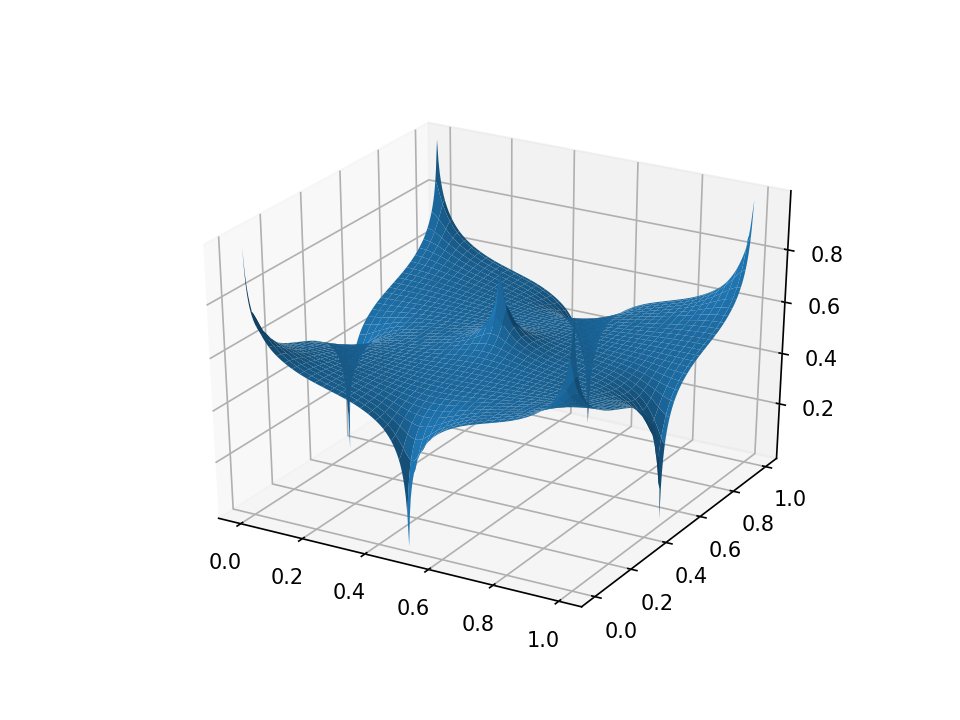

In [56]:
plot_height_map(hm)

# Part 2
We use linear solution to solve this problem

In [10]:
ML = sparse.vstack((M, L))
Z = sparse.csr_matrix(np.zeros((9,9)))
Zs = np.zeros((PIXELS, 1))
Cs = C.toarray()
LZ = sparse.vstack((L.T, Z))
A = sparse.hstack((ML, LZ))

b = np.vstack((Zs, Cs)).reshape(-1)

In [11]:
linear_hm_res = sparse.linalg.lsqr(A.tocsr(), b)

linear_hm = linear_hm_res[0][:-9].reshape(WIDTH, WIDTH)
linear_lf = linear_hm_res[0][-9:]

<IPython.core.display.Javascript object>


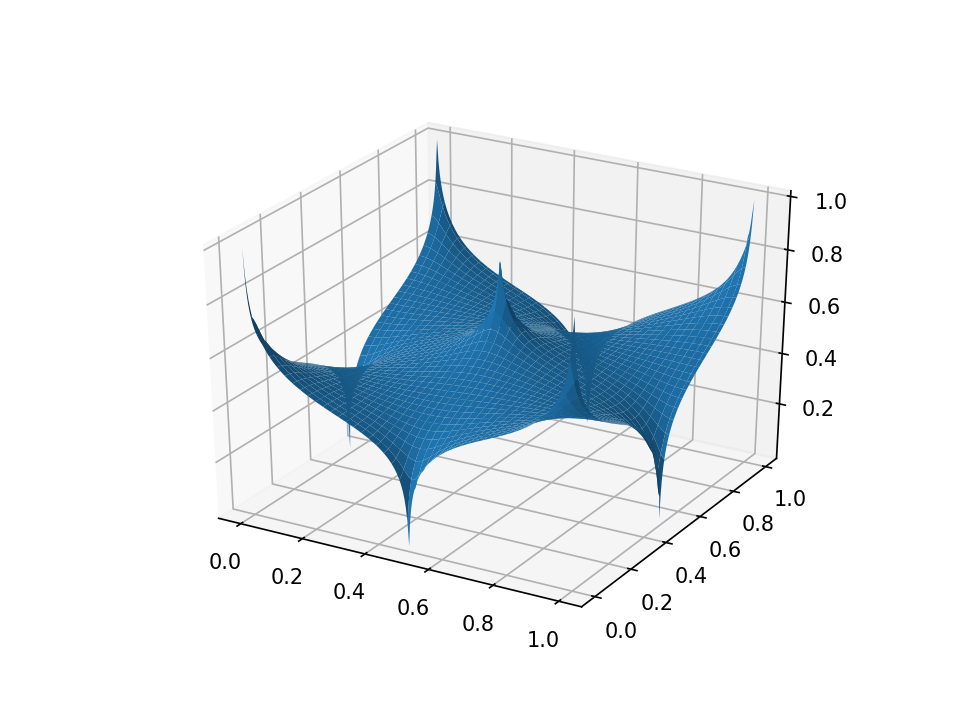

In [55]:
plot_height_map(linear_hm)

# Part 3
We define new constraints that interpolates along grid lines, with new objective that is minimizing surface area.


In [43]:
height_map = np.zeros((WIDTH, WIDTH), np.float32)

all_intp = interpolations.copy()

r0 = 0
r1 = WIDTH // 2 - 1
r2 = WIDTH - 1
intp = []
for i in range(1, WIDTH//2):
    s = WIDTH * i / (WIDTH//2)
    # 0, 0, 1 => 0, 1, 0
    # 0, 0, 1 => 1, 0, 0
    # 0, 1, 0 => 0, 2, 1
    # 0, 1, 0 => 1, 1, 1
    # 1, 0, 0 => 1, 1, 1
    # 1, 0, 0 => 2, 0, 1
    # 0, 2, 1 => 1, 2, 0
    # 1, 1, 1 => 1, 2, 0
    # 1, 1, 1 => 2, 1, 0
    # 2, 0, 1 => 2, 1, 0
    # 1, 2, 0 => 2, 2, 1
    # 2, 1, 0 => 2, 2, 1
    intp.append([r0   , r0 +i, WIDTH - s])
    intp.append([r0 +i, r0   , WIDTH - s])
    intp.append([r0   , r1 +i, 0 + s])
    intp.append([r0 +i, r1   , 0 + s])
    intp.append([r1   , r0 +i, 0 + s])
    intp.append([r1 +i, r0   , 0 + s])
    intp.append([r0 +i, r2   , WIDTH - s])
    intp.append([r1   , r1 +i, WIDTH - s])
    intp.append([r1 +i, r1   , WIDTH - s])
    intp.append([r2   , r0 +i, WIDTH - s])
    intp.append([r1 +i, r2   , 0 + s])
    intp.append([r2   , r1 +i, 0 + s])
all_interpolations = np.vstack((all_intp, np.array(intp)))
l_num_i = all_interpolations.shape[0]
l_coords = all_interpolations[:, 0:2].astype(np.int)
l_values = all_interpolations[:, 2]

In [44]:
height_map = np.zeros((WIDTH, WIDTH), np.float32)
height_map[l_coords[:, 0], l_coords[:, 1]] = l_values

In [45]:
Os = sparse.csr_matrix(np.ones((PIXELS, 1), np.float))

L3_array = np.zeros((l_num_i, WIDTH, WIDTH), np.float)

for i in range(l_num_i):
    L3_array[i, l_coords[i, 0], l_coords[i, 1]] = 1
C3_array = np.zeros((l_num_i, 1), np.float)

C3_array[:, 0] = l_values
L3 = sparse.csr_matrix(L3_array.reshape(l_num_i, -1))
C3 = sparse.csr_matrix(C3_array)

In [46]:
def f3(hm):
    hx = dx.dot(hm)
    hy = dy.dot(hm)
    v = hx.multiply(hx) + hy.multiply(hy) + Os
    return v.sqrt().sum()
    
def g3(hm):
    v = L3.dot(hm) - C3
    return v

def df3(hm):
    hx = dx.dot(hm)
    hy = dy.dot(hm)
    d = M.dot(hm)
    v = hx.multiply(hx) + hy.multiply(hy) + Os
    return d.multiply(v.sqrt().power(-1))


def dg3(hm):
    return L3

We use initial multiplier value of 1/32, because it falls into local minimum if we use 1 like we do in other problems.

In [51]:
hm3 = height_map.reshape(-1, 1)

lf = np.ones(l_num_i, np.float)
cf = 1 / 32
hm3 = ALM(hm3, lf, cf, f3, g3, df3, dg3)

1/10 iteration started
elapsed 1.69s
2/10 iteration started
elapsed 5.27s
3/10 iteration started
elapsed 2.57s
4/10 iteration started
elapsed 9.54s
5/10 iteration started
elapsed 5.72s
6/10 iteration started
elapsed 1.36s
7/10 iteration started
elapsed 0.17s
8/10 iteration started
elapsed 0.32s
9/10 iteration started
elapsed 0.23s
10/10 iteration started
elapsed 0.18s


<IPython.core.display.Javascript object>


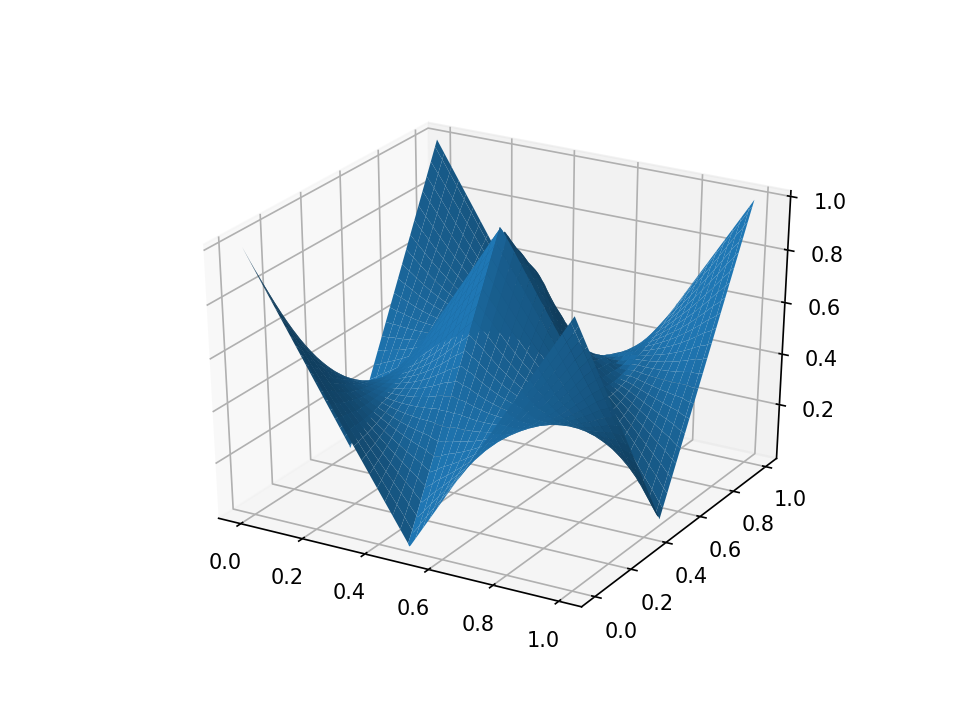

In [52]:
plot_height_map(hm3)

# Part 4
We try using constraints from Part 1, and objectives from part 3. with ALM

In [19]:
def f4(hm):
    hx = dx.dot(hm)
    hy = dy.dot(hm)
    v = hx.multiply(hx) + hy.multiply(hy) + Os
    return v.sqrt().sum()
    
def g4(hm):
    v = L.dot(hm) - C
    return v

def df4(hm):
    hx = dx.dot(hm)
    hy = dy.dot(hm)
    d = M.dot(hm)
    v = hx.multiply(hx) + hy.multiply(hy) + Os
    return d.multiply(v.sqrt().power(-1))

def dg4(hm):
    return L


In [20]:
hm4 = height_map.reshape(-1, 1)

lf = np.ones(num_intp, np.float)
cf = 1
hm4 = ALM(hm4, lf, cf, f4, g4, df4, dg4)

1/10 iteration started
elapsed 5.37s
2/10 iteration started
elapsed 3.20s
3/10 iteration started
elapsed 11.65s
4/10 iteration started
elapsed 2.24s
5/10 iteration started
elapsed 0.17s
6/10 iteration started
elapsed 0.16s
7/10 iteration started
elapsed 0.17s
8/10 iteration started
elapsed 0.16s
9/10 iteration started
elapsed 0.18s
10/10 iteration started
elapsed 0.43s


<IPython.core.display.Javascript object>


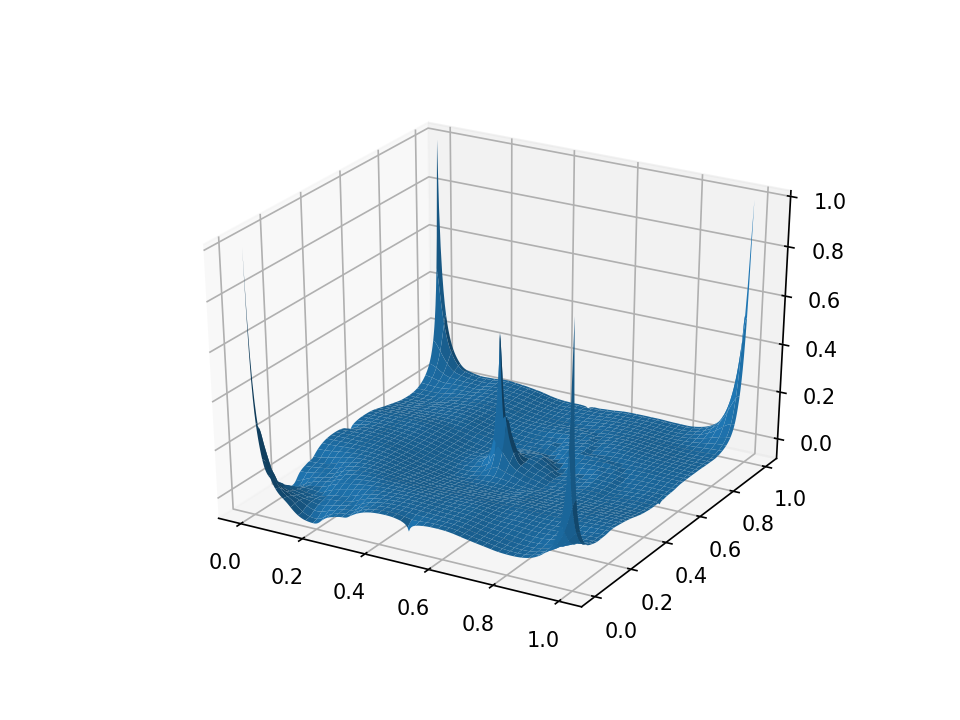

In [53]:
plot_height_map(hm4)

<IPython.core.display.Javascript object>


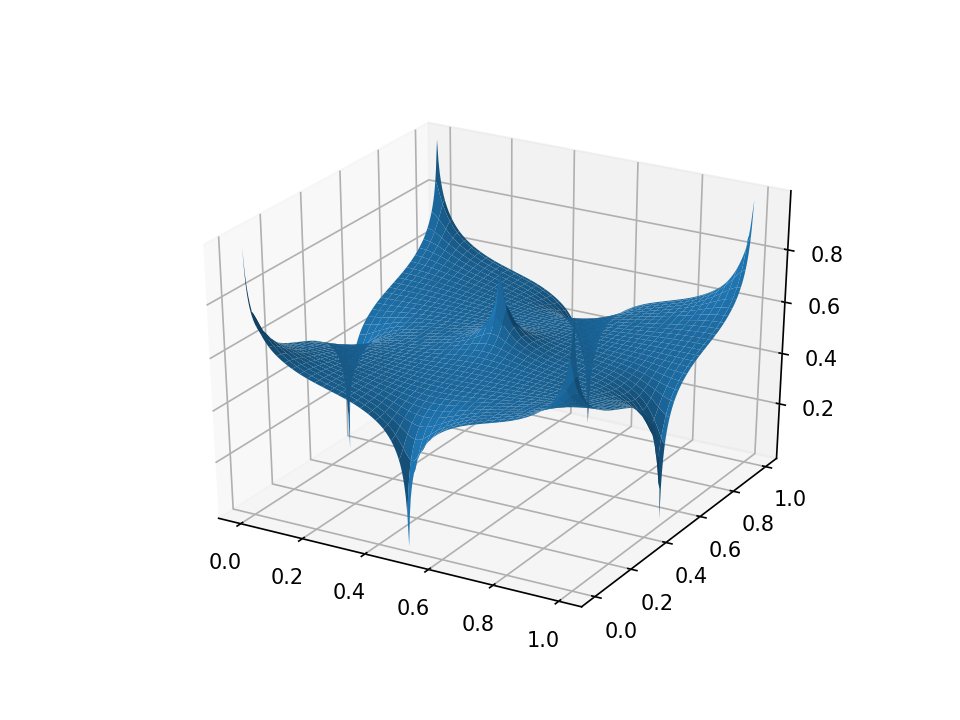

<IPython.core.display.Javascript object>


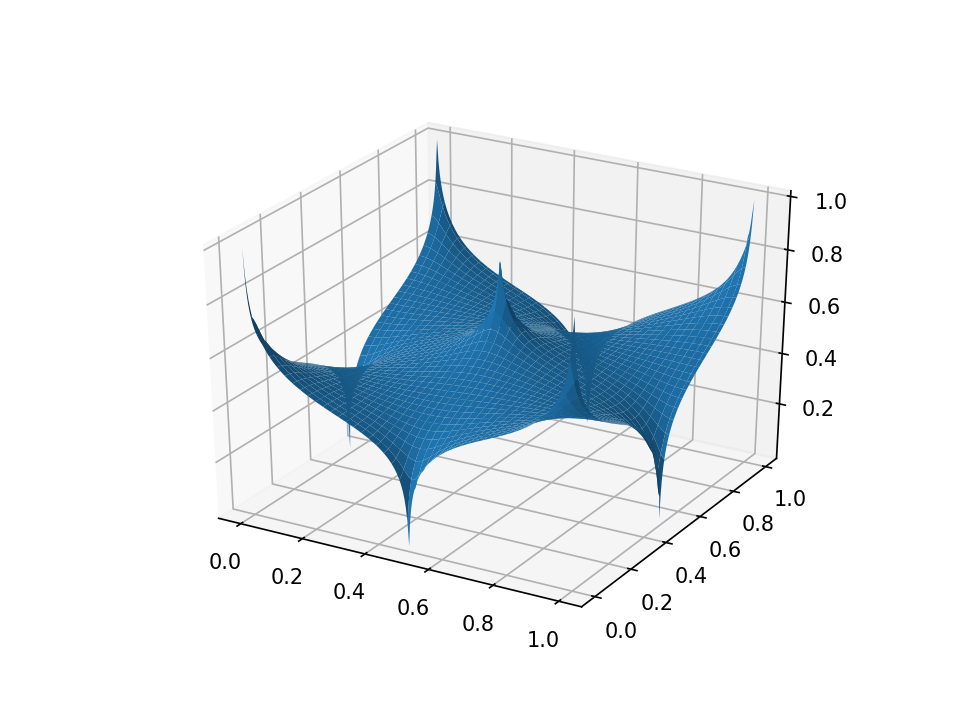

<IPython.core.display.Javascript object>


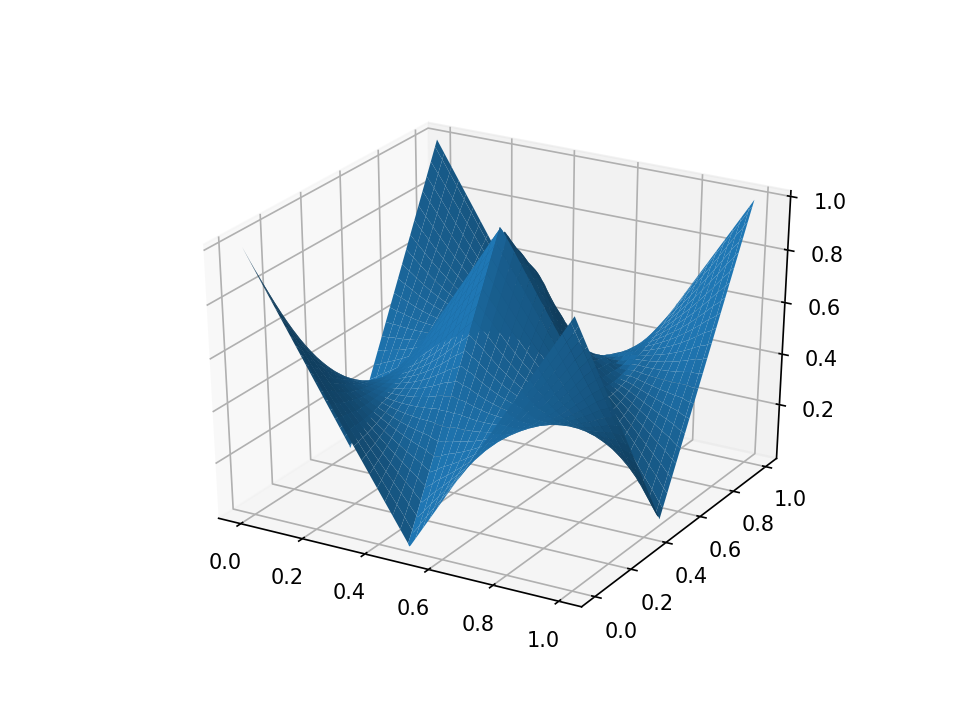

<IPython.core.display.Javascript object>


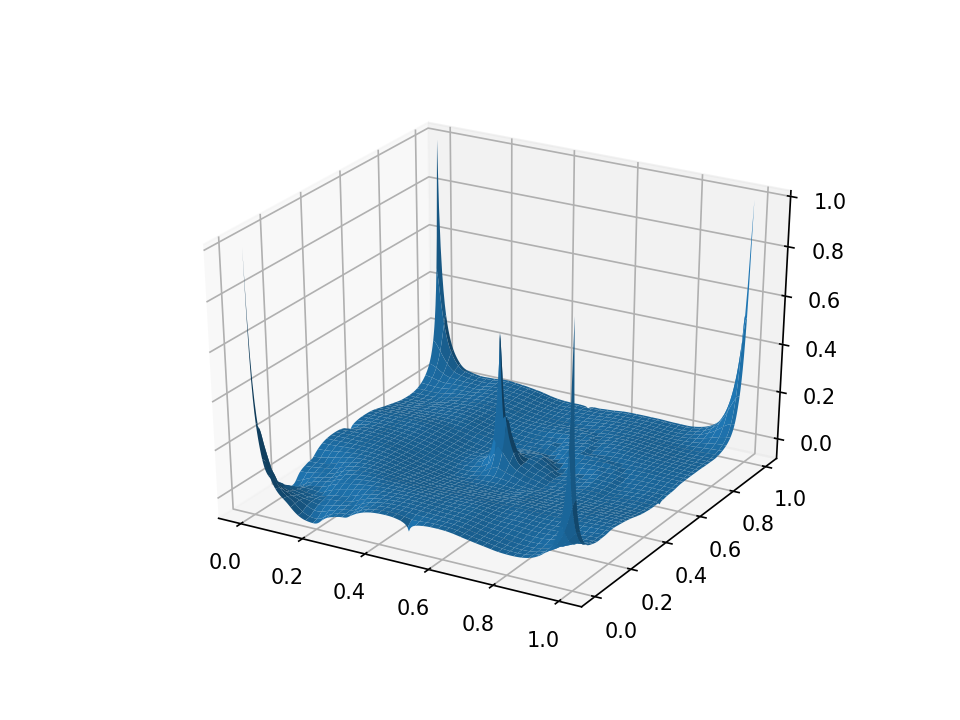

In [54]:
plot_height_map(hm)
plot_height_map(linear_hm)
plot_height_map(hm3)
plot_height_map(hm4)